## Recency, Frequency, Monetary

RFM model combines three different customer attributes to rank customers:
* **Recency (R)**: Who have purchased recently? Number of days since last purchase
* **Frequency (F)**: Who has purchased frequently? The total number of purchases
* **Monetary Value(M)**: Who has high purchase amount? The total money customer spent

If the customer bought in recent past, he gets higher points. If he bought many times, he gets higher score. And if he spent a lot of money, he gets more points.

How to create segments?
* Concatenate all scores into one, eg: 3-4-1 (R-F-M) and group customers according to those values. It gives 125 combinations which is difficult to depict and understand
* Sum all scores into one, eg: 8 (3 + 4 + 1) and group customers according to this number. It creates 13 groups which is much easier to work with but it disregards relations between R & F & M
* Segment customers based on set of rules applied to R-F-M scores. It creates 10 groups, such as "champions", "needing attention" or "at risk"

In [1]:
from pyhive import trino
from getpass import getpass
import pandas as pd
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils import *

In [37]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [19]:
df = wr.s3.read_parquet('s3://neon-datascience-sandbox/segmentacao-cartoes/card-use')
df_dimension = wr.s3.read_parquet('s3://neon-datascience-sandbox/segmentacao-cartoes/dimension')
df_gh = wr.s3.read_parquet('s3://neon-datascience-sandbox/segmentacao-cartoes/gh')
df_viracredito = wr.s3.read_parquet('s3://neon-datascience-sandbox/segmentacao-cartoes/viracredito')
df_account_balance = wr.s3.read_parquet('s3://neon-datascience-sandbox/segmentacao-cartoes/account-balance')
df_limite_credito = wr.s3.read_parquet('s3://neon-datascience-sandbox/segmentacao-cartoes/credito')

In [20]:
df_gh_agg = df_gh.groupby('clientid')['GH_VL'].max().to_frame().reset_index()

df_viracredito_agg = df_viracredito.groupby('clientid')['tem_viracredito'].sum().to_frame().reset_index()
df_viracredito_agg['viracredito_flag'] = 1
del df_viracredito_agg['tem_viracredito']

In [21]:
df = df.merge(df_dimension, on = 'clientid', how = 'left')
df = df.merge(df_gh_agg, on = 'clientid', how = 'left')
df = df.merge(df_viracredito_agg, on = 'clientid', how = 'left')
df = df.merge(df_account_balance , on = 'clientid', how = 'left')
df = df.merge(df_limite_credito , on = 'clientid', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313639 entries, 0 to 2313638
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   clientid                 Int64  
 1   RECENCY                  Int64  
 2   FREQUENCY                Int64  
 3   MONETARY                 float64
 4   presumedincome           float64
 5   age                      float64
 6   ageneon                  Int64  
 7   flaginviteduser          Int64  
 8   GH_VL                    float64
 9   viracredito_flag         float64
 10  ACCOUNT_BALANCE_VL       float64
 11  limitecreditototal       float64
 12  debitoautomatico         boolean
 13  limitecreditodisponivel  float64
 14  diasatraso               float64
dtypes: Int64(5), boolean(1), float64(9)
memory usage: 280.2 MB


## RFM Customer Segments

* **Champions** - bought recently, buy often and spend the most
* **Loyal Customers** - spend good money and often, responsive to promotions
* **Potential Loyalist** - recent customers, but spent a good amount and bought more than once
* **New Customers** - bought most recently, but not often
* **Promising** - recent shoppers, but haven’t spent much
* **Needing Attention** - above average recency, frequency and monetary values; may not have bought very recently though
* **About To Sleep** - below average recency, frequency and monetary values; will lose them if not reactivated
* **At Risk** - spent big money and purchased often but long time ago; need to bring them back
* **Can't Loose Them** - made biggest purchases, and often but haven’t returned for a long time
* **Hibernating** - last purchase was long back, low spenders and low number of orders

In [22]:
df["R"] = pd.qcut(df["RECENCY"],5,labels=[5,4,3,2,1])

df["F"] = pd.qcut(df["FREQUENCY"],5,labels=[1,2,3,4,5])

df["M"] = pd.qcut(df["MONETARY"],5,labels=[1,2,3,4,5])

In [23]:
df["RFM_Score"] = df["R"].astype(str) + df["F"].astype(str) + df["M"].astype(str)

In [38]:
df.head(3)

,clientid,RECENCY,FREQUENCY,MONETARY,presumedincome,age,ageneon,flaginviteduser,GH_VL,viracredito_flag,ACCOUNT_BALANCE_VL,limitecreditototal,debitoautomatico,limitecreditodisponivel,diasatraso,R,F,M,RFM_Score,Segment
0,12345,0,18,3231.26,1559.09,30.00,83,0,7.00,NaN,601.15,4004.00,False,2203.48,3.00,5,4,5,545,Champions
1,16789075,0,6,902.01,2110.00,49.00,17,0,10.00,NaN,NaN,4250.00,False,1692.63,1.00,5,2,4,524,Potential Loyalists
2,22141562,0,3,337.90,1006.00,30.00,8,0,10.00,1.00,34.62,693.00,False,47.54,6.00,5,1,2,512,New Customers


In [26]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Cant Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [27]:
df['Segment'] = df['R'].astype(str) + df['F'].astype(str)
df['Segment'] = df['Segment'].replace(seg_map, regex=True)
df.head()

,clientid,RECENCY,FREQUENCY,MONETARY,presumedincome,age,ageneon,flaginviteduser,GH_VL,viracredito_flag,ACCOUNT_BALANCE_VL,limitecreditototal,debitoautomatico,limitecreditodisponivel,diasatraso,R,F,M,RFM_Score,Segment
0,12345,0,18,3231.26,1559.09,30.0,83,0,7.0,NaN,601.15,4004.0,False,2203.48,3.0,5,4,5,545,Champions
1,16789075,0,6,902.01,2110.00,49.0,17,0,10.0,NaN,NaN,4250.0,False,1692.63,1.0,5,2,4,524,Potential Loyalists
2,22141562,0,3,337.90,1006.00,30.0,8,0,10.0,1.0,34.62,693.0,False,47.54,6.0,5,1,2,512,New Customers
3,18388465,0,7,191.91,1211.98,45.0,15,1,9.0,NaN,7115.17,600.0,False,278.08,6.0,5,2,2,522,Potential Loyalists
4,8050971,0,6,537.82,1108.88,34.0,36,0,10.0,NaN,0.00,2700.0,True,2030.83,0.0,5,2,3,523,Potential Loyalists


In [28]:
segment_order = ['Hibernating',
                 'At Risk',
                 'Cant Loose',
                 'About to Sleep',
                 'Need Attention',
                 'Loyal Customers',
                 'Promising',
                 'New Customers',
                 'Potential Loyalists',
                 'Champions']

In [43]:
segment_means = df.groupby('Segment').agg({
    'RECENCY': 'mean',
    'FREQUENCY': 'mean',
    'MONETARY': 'mean',
    'presumedincome': 'mean', 
    'age': 'mean',
    'ageneon': 'mean', 
    'flaginviteduser': 'sum', 
    'GH_VL': 'mean', 
    'viracredito_flag': 'sum',
    'ACCOUNT_BALANCE_VL': 'mean', 
    'limitecreditototal': 'mean', 
    'debitoautomatico':'sum',
    'limitecreditodisponivel': 'mean', 
    'diasatraso': 'mean',
    'clientid': 'count'
}).reset_index().rename(columns={'clientid': 'count'})

segment_means['Segment'] = segment_means['Segment'].astype('string')

In [30]:
segment_means.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Segment                  10 non-null     string 
 1   RECENCY                  10 non-null     Float64
 2   FREQUENCY                10 non-null     Float64
 3   MONETARY                 10 non-null     float64
 4   presumedincome           10 non-null     float64
 5   age                      10 non-null     float64
 6   ageneon                  10 non-null     Float64
 7   flaginviteduser          10 non-null     Int64  
 8   GH_VL                    10 non-null     float64
 9   viracredito_flag         10 non-null     float64
 10  ACCOUNT_BALANCE_VL       10 non-null     float64
 11  limitecreditototal       10 non-null     float64
 12  debitoautomatico         10 non-null     Int64  
 13  limitecreditodisponivel  10 non-null     float64
 14  diasatraso               10 n

In [44]:
segment_means

,Segment,RECENCY,FREQUENCY,MONETARY,presumedincome,age,ageneon,flaginviteduser,GH_VL,viracredito_flag,ACCOUNT_BALANCE_VL,limitecreditototal,debitoautomatico,limitecreditodisponivel,diasatraso,count
0,About to Sleep,6.92,4.05,455.14,1570.71,34.90,23.43,22980,7.59,44600.00,6757.43,1400.28,95168,860.34,9.52,158397
1,At Risk,17.48,13.34,997.14,1580.99,35.10,25.65,38954,7.55,56681.00,5340.57,1519.27,145808,863.12,4.62,260575
2,Cant Loose,15.49,37.12,1947.28,1669.78,35.02,25.0,8599,7.45,13362.00,5508.66,1935.27,31954,1173.00,2.61,58371
3,Champions,1.17,35.13,2045.49,1793.44,36.07,26.0,70949,7.82,73642.00,8894.19,2749.86,230142,1632.66,1.73,439516
4,Hibernating,25.65,3.08,383.41,1557.40,34.75,23.97,85219,7.23,200283.00,5536.46,1182.17,357543,580.11,17.00,595490
5,Loyal Customers,5.26,28.46,1679.59,1679.69,35.28,26.34,49846,7.70,56480.00,7576.28,2205.51,161711,1331.90,2.09,306976
6,Need Attention,6.83,10.29,857.94,1586.41,35.21,25.9,15841,7.78,19697.00,7023.10,1713.52,56273,1028.61,3.89,101796
7,New Customers,1.36,2.19,279.44,1599.95,35.17,21.06,5881,7.59,12663.00,6653.67,1377.75,27082,874.63,12.35,43330
8,Potential Loyalists,1.99,8.44,752.97,1605.48,35.47,24.61,48147,7.87,60334.00,7474.04,1754.91,181938,1089.80,4.75,319882
9,Promising,3.48,2.12,272.68,1566.53,34.75,20.69,3851,7.49,10285.00,5847.54,1266.98,18716,865.51,10.41,29306


In [80]:
segment_means['percent_mgm'] = (segment_means['flaginviteduser'] / segment_means['count']) * 100
segment_means['percent_debt_auto'] = (segment_means['debitoautomatico'] / segment_means['count']) * 100
segment_means['percent_viracredito'] = (segment_means['viracredito_flag'] / segment_means['count']) * 100
segment_means['percent_limite'] = (segment_means['limitecreditodisponivel'] / segment_means['limitecreditototal']) * 100

In [64]:
segment_means['Segment'] = pd.Categorical(segment_means['Segment'], categories=segment_order, ordered=True)
segment_means = segment_means.sort_values('Segment')

In [65]:
segment_means

,Segment,RECENCY,FREQUENCY,MONETARY,presumedincome,age,ageneon,flaginviteduser,GH_VL,viracredito_flag,ACCOUNT_BALANCE_VL,limitecreditototal,debitoautomatico,limitecreditodisponivel,diasatraso,count
4,Hibernating,25.65,3.08,383.41,1557.40,34.75,23.97,85219,7.23,200283.00,5536.46,1182.17,357543,580.11,17.00,595490
1,At Risk,17.48,13.34,997.14,1580.99,35.10,25.65,38954,7.55,56681.00,5340.57,1519.27,145808,863.12,4.62,260575
2,Cant Loose,15.49,37.12,1947.28,1669.78,35.02,25.0,8599,7.45,13362.00,5508.66,1935.27,31954,1173.00,2.61,58371
0,About to Sleep,6.92,4.05,455.14,1570.71,34.90,23.43,22980,7.59,44600.00,6757.43,1400.28,95168,860.34,9.52,158397
6,Need Attention,6.83,10.29,857.94,1586.41,35.21,25.9,15841,7.78,19697.00,7023.10,1713.52,56273,1028.61,3.89,101796
5,Loyal Customers,5.26,28.46,1679.59,1679.69,35.28,26.34,49846,7.70,56480.00,7576.28,2205.51,161711,1331.90,2.09,306976
9,Promising,3.48,2.12,272.68,1566.53,34.75,20.69,3851,7.49,10285.00,5847.54,1266.98,18716,865.51,10.41,29306
7,New Customers,1.36,2.19,279.44,1599.95,35.17,21.06,5881,7.59,12663.00,6653.67,1377.75,27082,874.63,12.35,43330
8,Potential Loyalists,1.99,8.44,752.97,1605.48,35.47,24.61,48147,7.87,60334.00,7474.04,1754.91,181938,1089.80,4.75,319882
3,Champions,1.17,35.13,2045.49,1793.44,36.07,26.0,70949,7.82,73642.00,8894.19,2749.86,230142,1632.66,1.73,439516


## Plotting RECENCY, FREQUENCY and MONETARY

Clients qty by segment

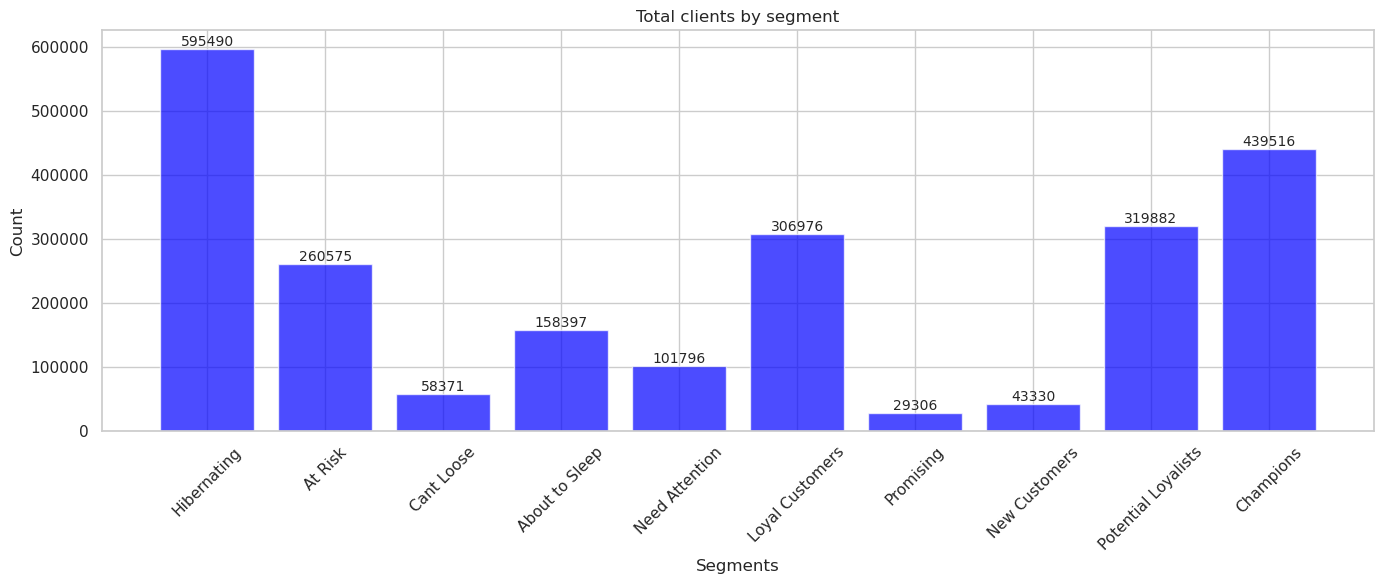

In [66]:
plot_bar(segment_means, 'count', 'Segments', 'Count', 'Total clients by segment', 'blue')

Mean <b>RECENCY</b>  by segment

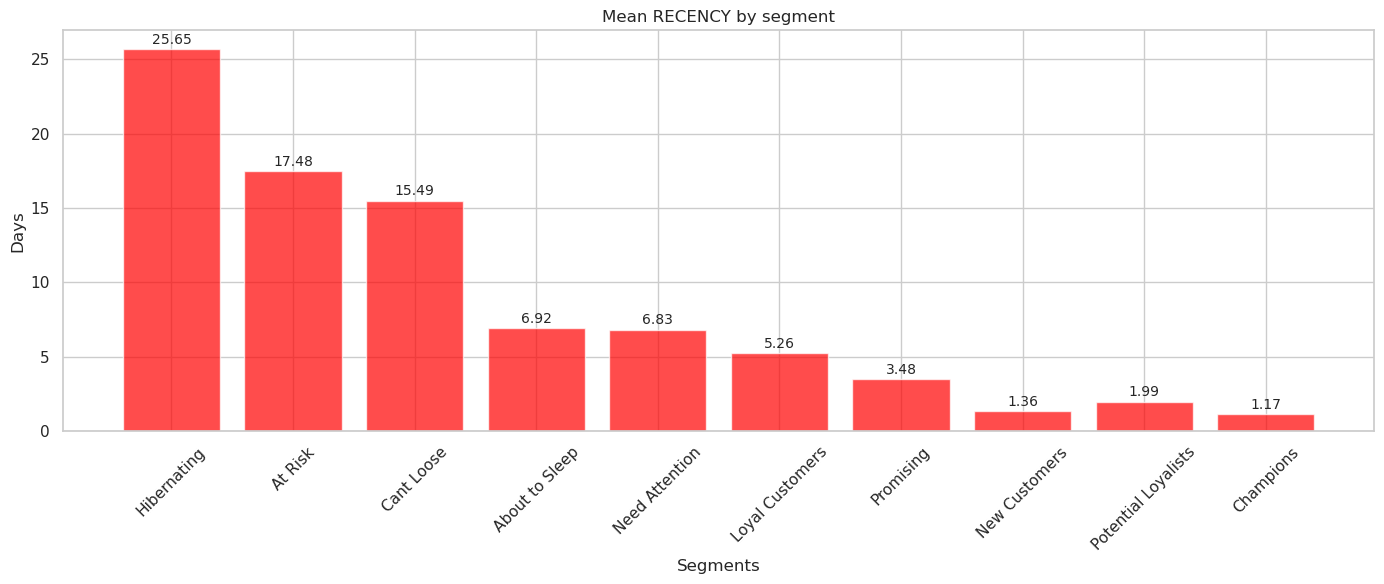

In [67]:
plot_bar(segment_means, 'RECENCY', 'Segments', 'Days', 'Mean RECENCY by segment', 'red')

Mean <b>FREQUENCY</b> by segment

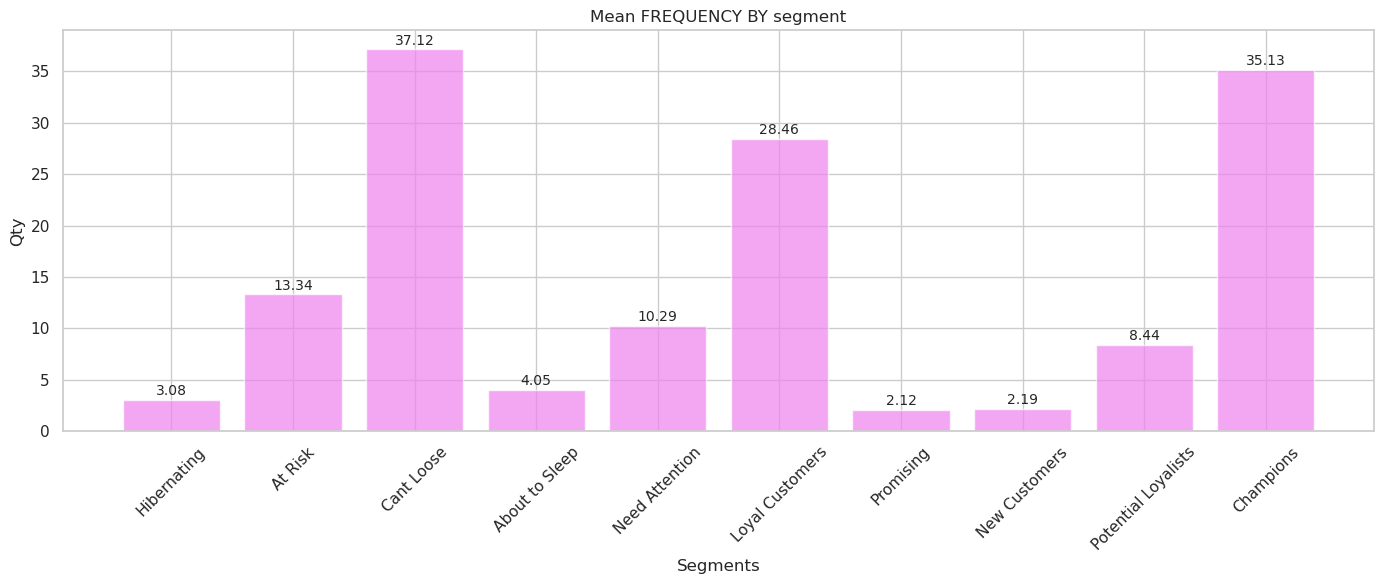

In [68]:
plot_bar(segment_means, 'FREQUENCY', 'Segments', 'Qty', 'Mean FREQUENCY BY segment', 'violet')

Mean <b>MONETARY</b> spending by segment

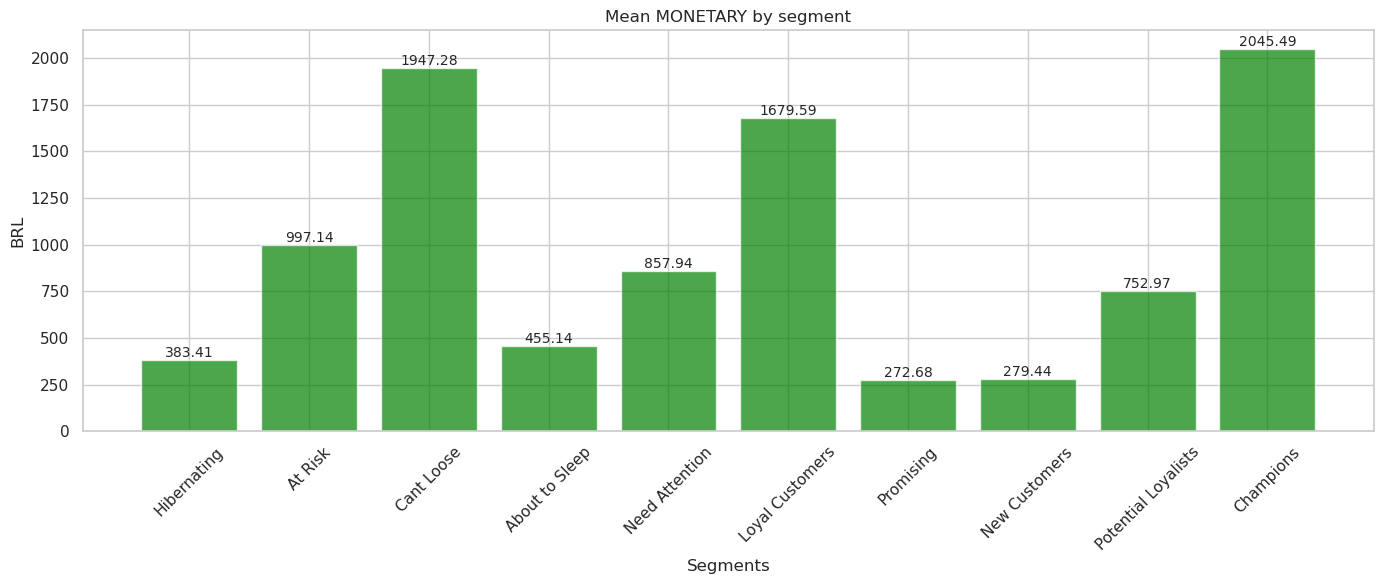

In [69]:
plot_bar(segment_means, 'MONETARY', 'Segments', 'BRL', 'Mean MONETARY by segment', 'green')

## Plotting of complementary data

PresumedIncome

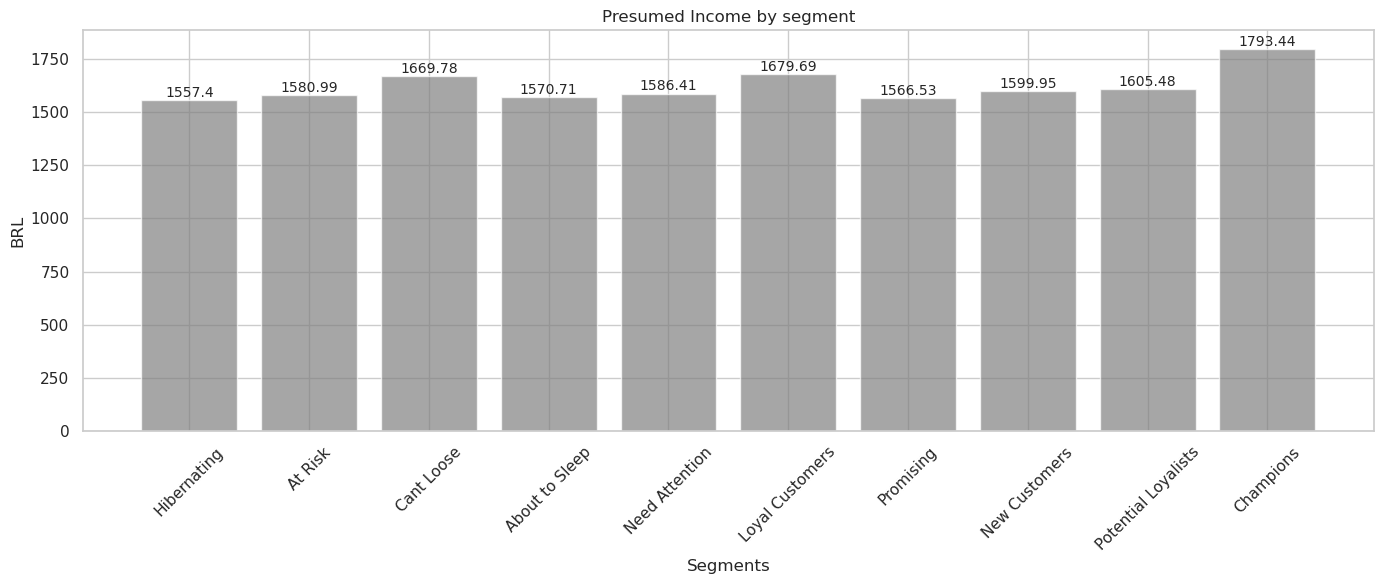

In [70]:
plot_bar(segment_means, 'presumedincome', 'Segments', 'BRL', 'Presumed Income by segment', 'grey')

<AxesSubplot:ylabel='presumedincome'>

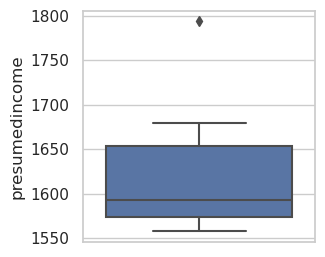

In [57]:
sns.set(rc={'figure.figsize':(3,3)}, style='whitegrid')
sns.boxplot(
             y ="presumedincome",
             data = segment_means)

Age of client

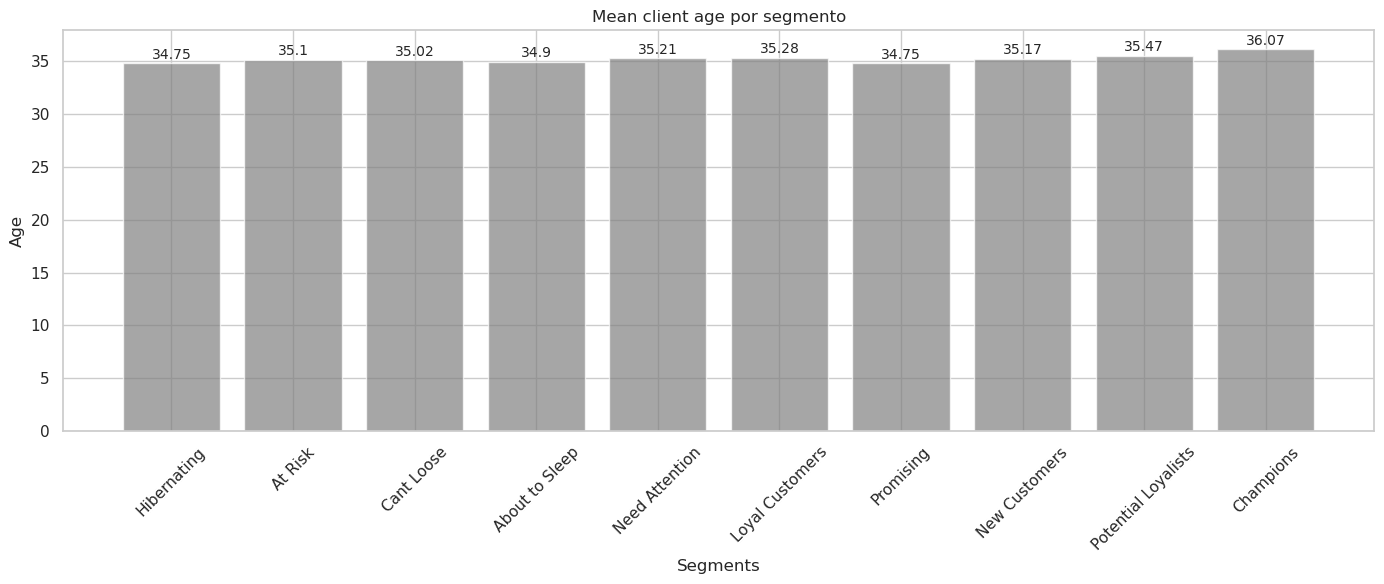

In [71]:
plot_bar(segment_means, 'age', 'Segments', 'Age', 'Mean client age por segmento', 'grey')

<AxesSubplot:ylabel='age'>

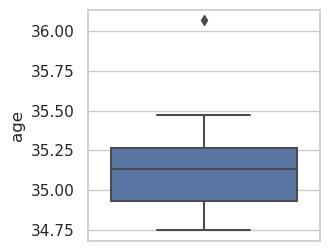

In [58]:
sns.set(rc={'figure.figsize':(3,3)}, style='whitegrid')
sns.boxplot(
             y ="age",
             data = segment_means)

AgeNeon : client relationshipo time with Neon

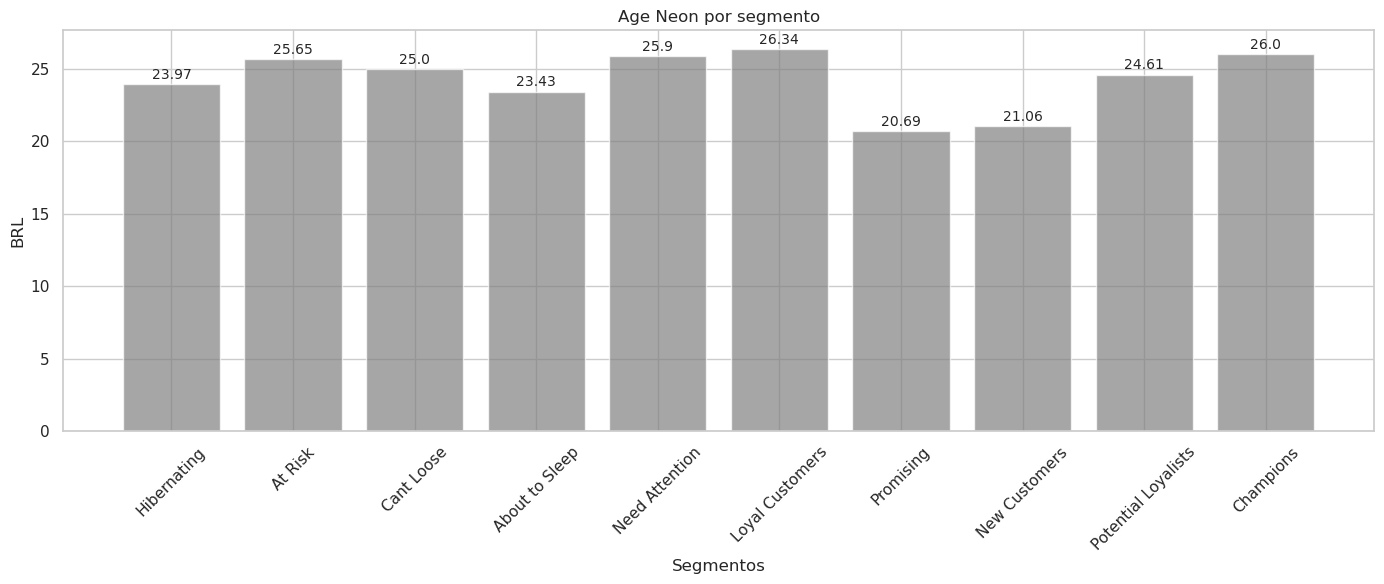

In [72]:
plot_bar(segment_means, 'ageneon', 'Segmentos', 'BRL', 'Age Neon por segmento', 'grey')

<AxesSubplot:ylabel='ageneon'>

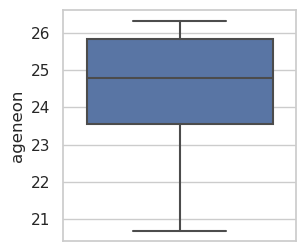

In [61]:
sns.set(rc={'figure.figsize':(3,3)}, style='whitegrid')
sns.boxplot(
             y ="ageneon",
             data = segment_means)

Risk GH

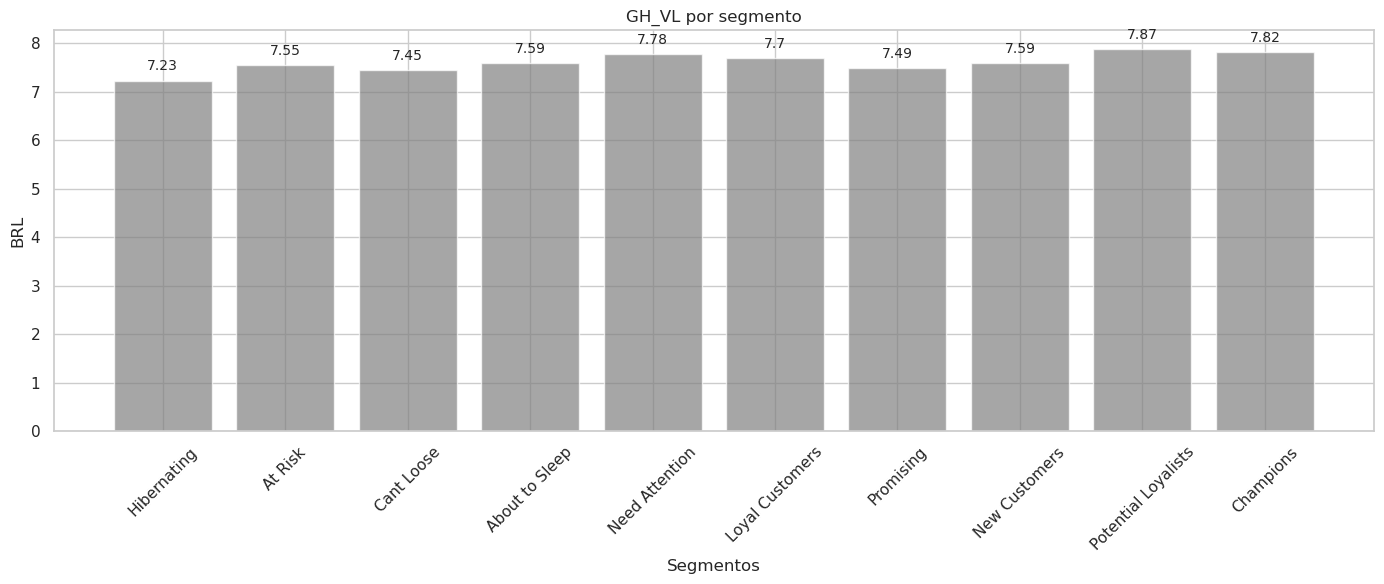

In [73]:
plot_bar(segment_means, 'GH_VL', 'Segmentos', 'BRL', 'GH_VL por segmento', 'grey')

<AxesSubplot:ylabel='GH_VL'>

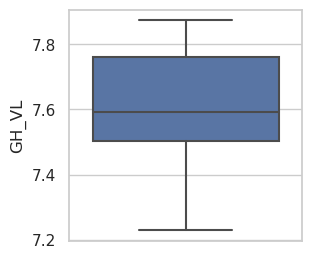

In [62]:
sns.set(rc={'figure.figsize':(3,3)}, style='whitegrid')
sns.boxplot(
             y ="GH_VL",
             data = segment_means)

Account Balance

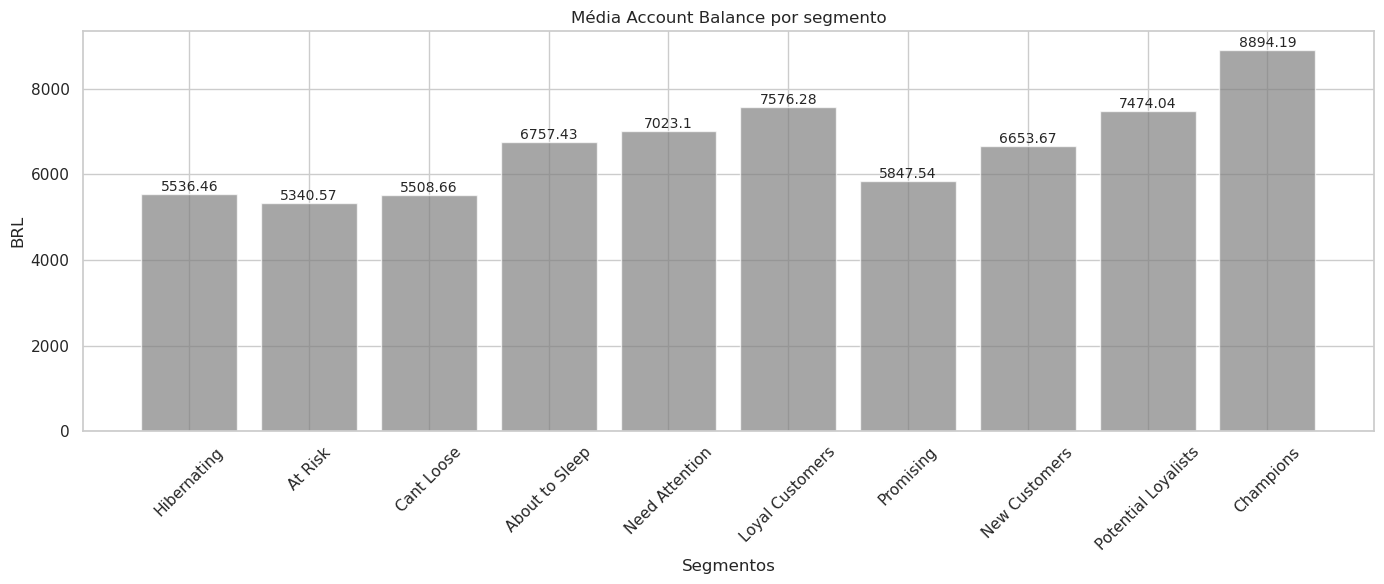

In [75]:
plot_bar(segment_means, 'ACCOUNT_BALANCE_VL', 'Segmentos', 'BRL', 'Média Account Balance por segmento', 'grey')

Payment Delay 

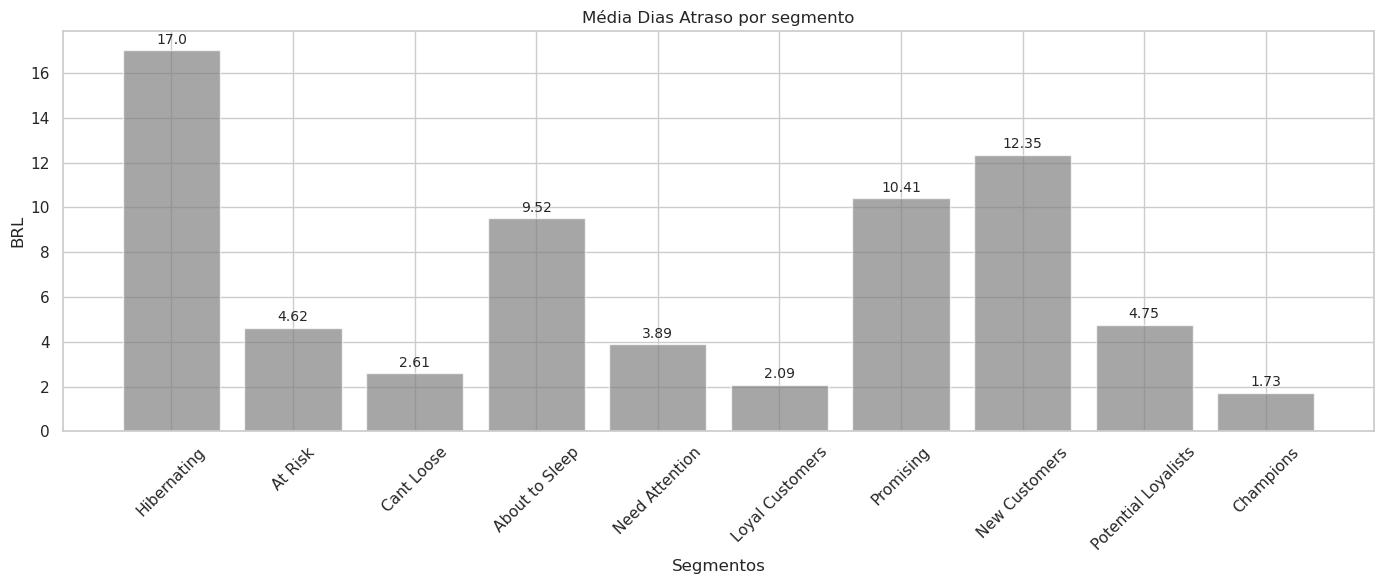

In [76]:
plot_bar(segment_means, 'diasatraso', 'Segmentos', 'BRL', 'Média Dias Atraso por segmento' , 'grey')

Total Credit Limit

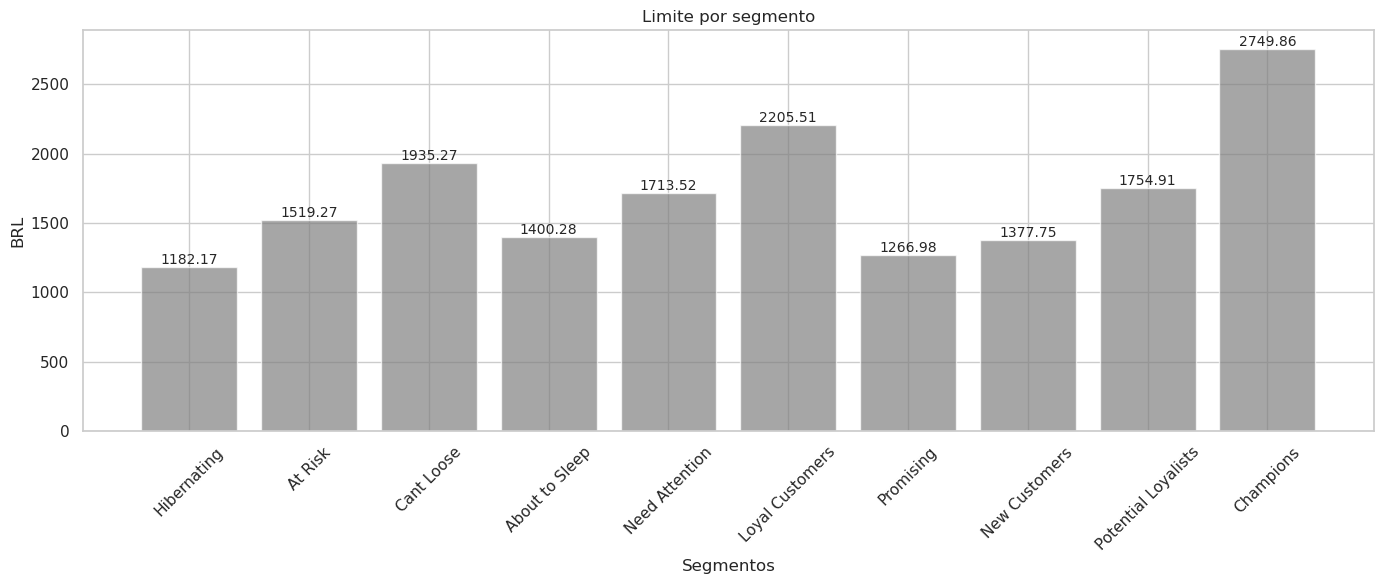

In [77]:
plot_bar(segment_means, 'limitecreditototal', 'Segmentos', 'BRL', 'Limite por segmento', 'grey')

Available Credit Limit

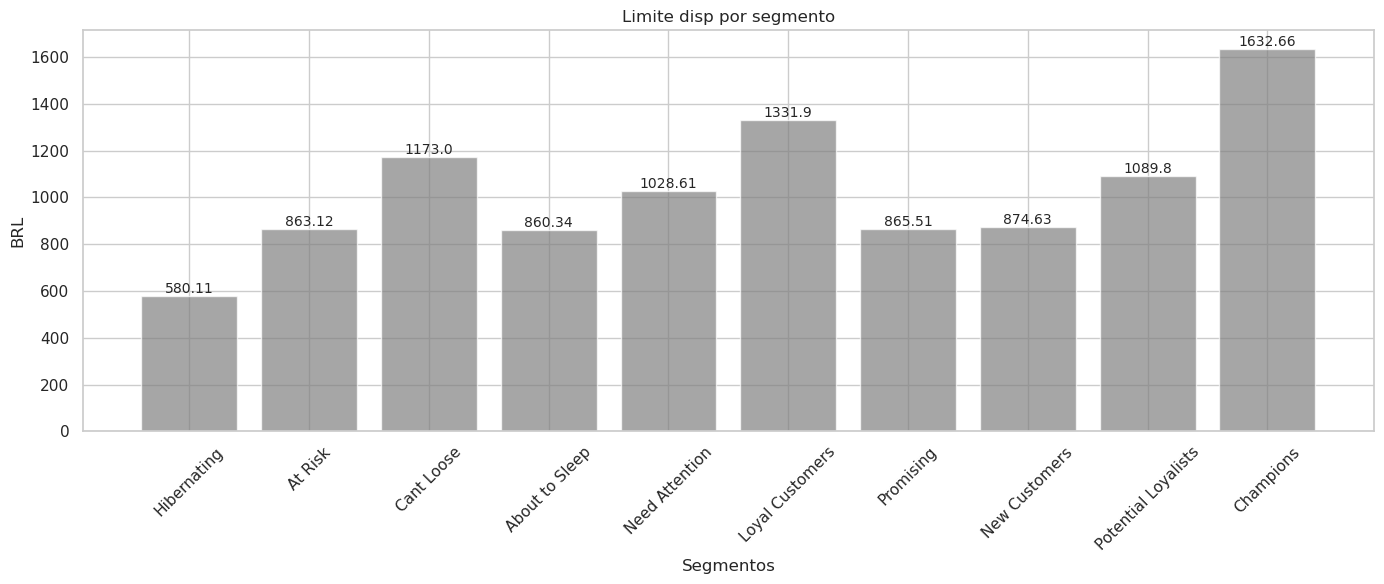

In [94]:
plot_bar(segment_means, 'limitecreditodisponivel', 'Segmentos', 'BRL', 'Limite disp por segmento', 'grey')

% Used Credit Limit

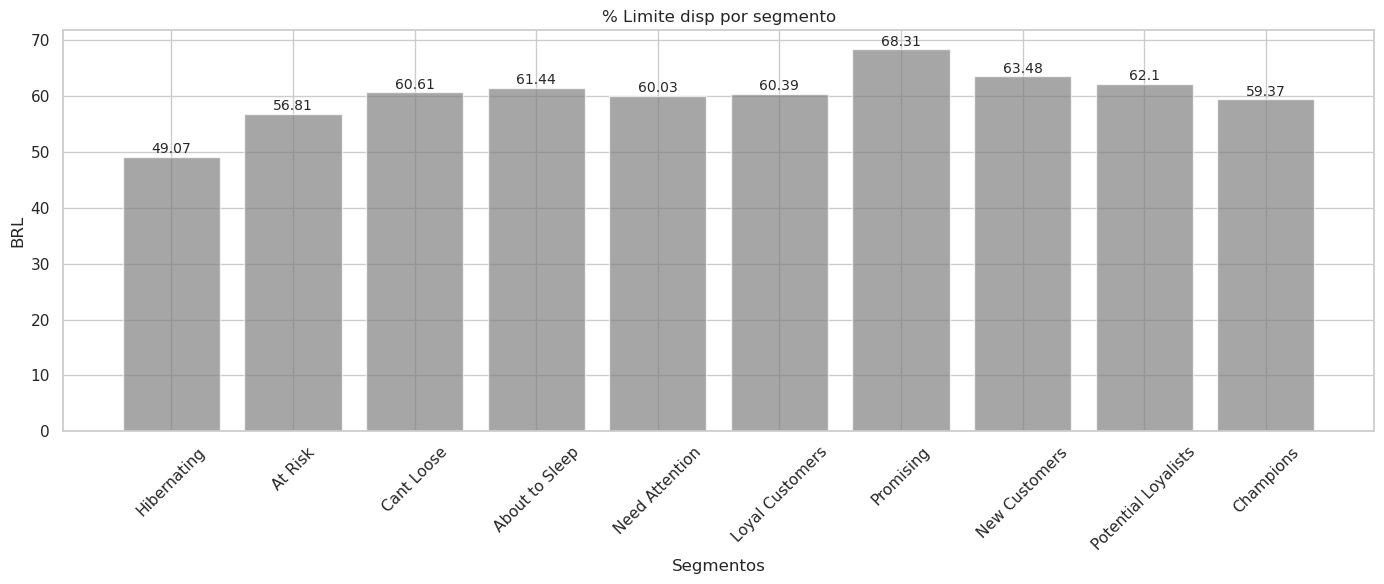

In [86]:
plot_bar(segment_means, 'percent_limite', 'Segmentos', 'BRL', '% Limite disp por segmento', 'grey')

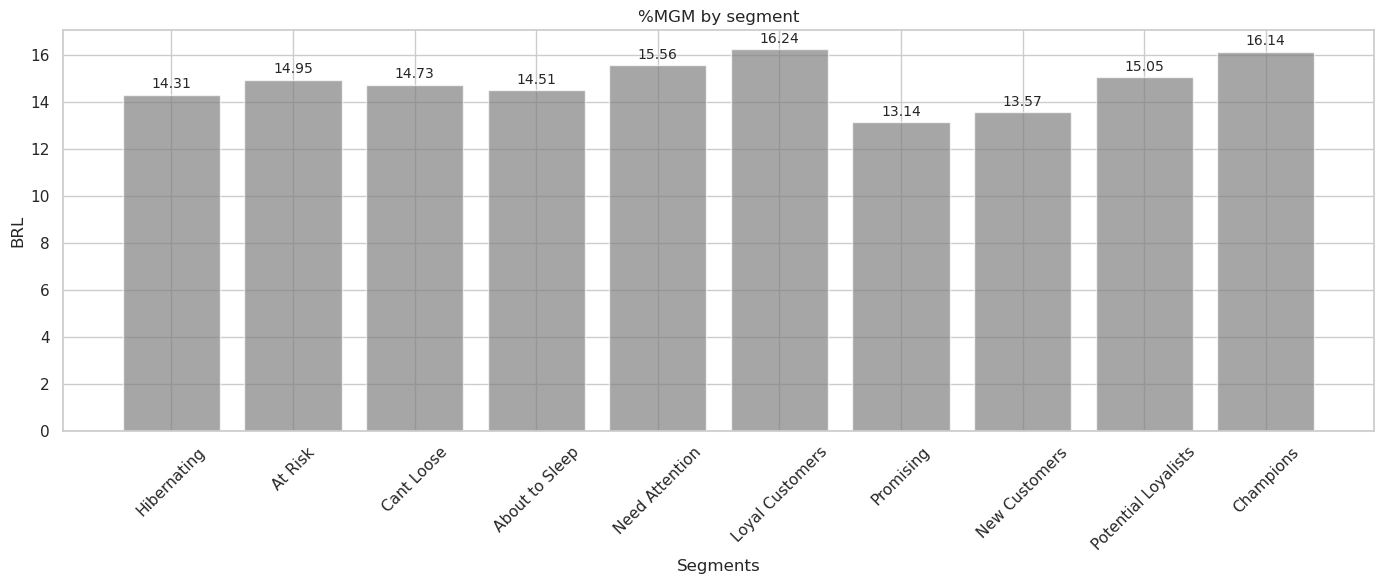

In [85]:
plot_bar(segment_means, 'percent_mgm', 'Segments', 'BRL', '%MGM by segment', 'grey')

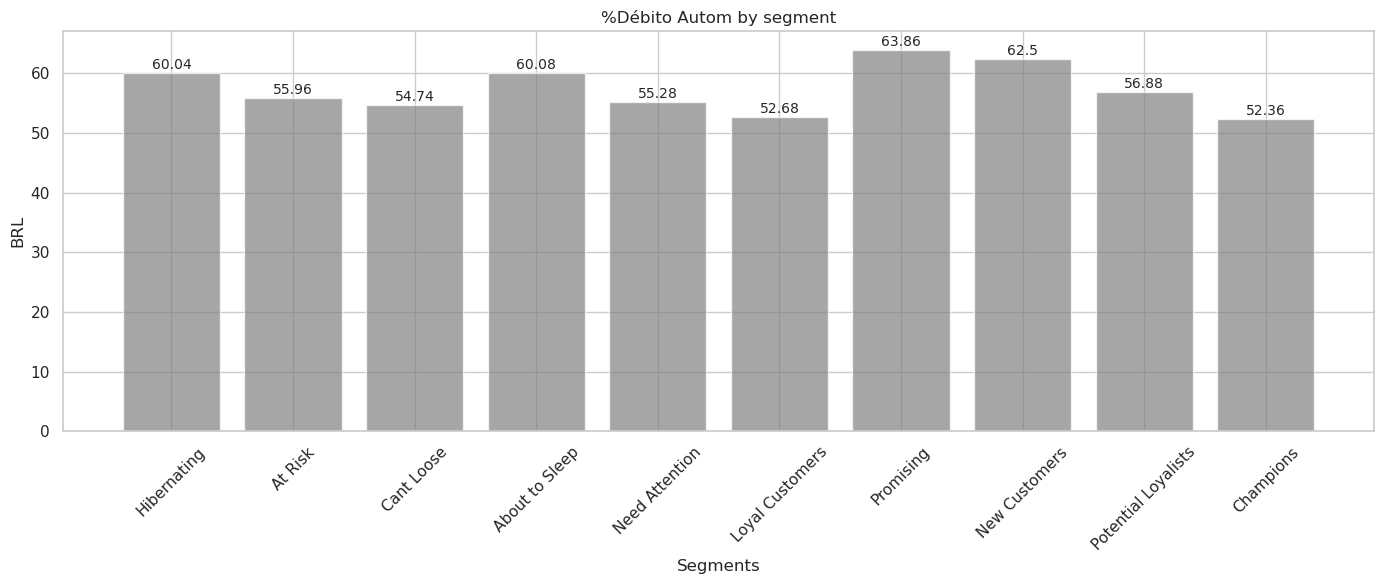

In [88]:
plot_bar(segment_means, 'percent_debt_auto', 'Segments', 'BRL', '%Débito Autom by segment', 'grey')

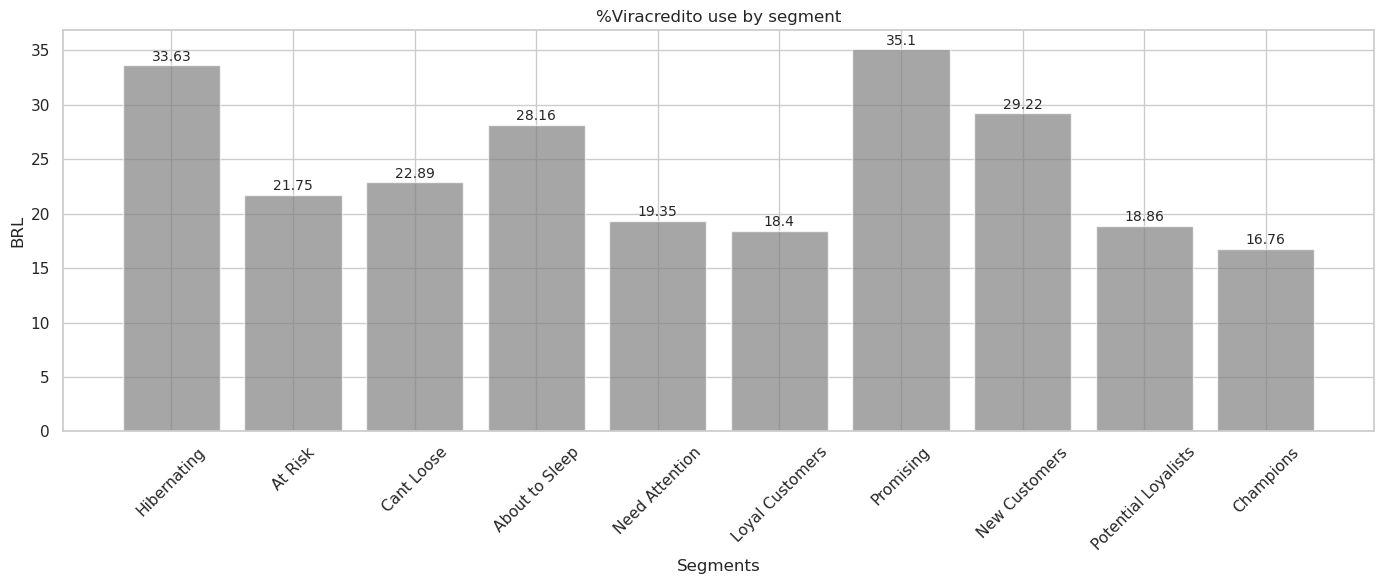

In [89]:
plot_bar(segment_means, 'percent_viracredito', 'Segments', 'BRL', '%Viracredito use by segment', 'grey')